In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: nvcc: command not found
torch:  1.11 ; cuda:  1.11.0
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from matplotlib import image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

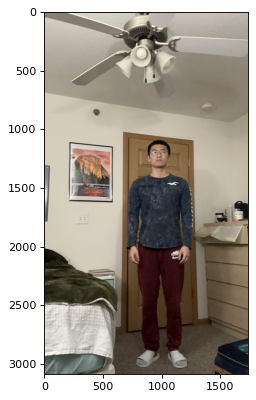

In [61]:
im = image.imread("/Users/xin/Desktop/millimeter wave/code_exp/cloud_point/person.jpeg")
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(im)

In [62]:
# detectron_model = "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"
detectron_model = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(detectron_model))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(detectron_model)
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [63]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0, 59])
Boxes(tensor([[ 702.6587, 1075.2198, 1271.9592, 3054.3494],
        [   8.2411, 2000.8164,  635.3827, 3063.7109]]))


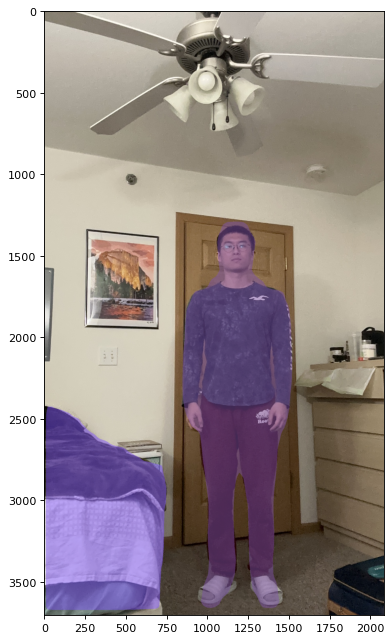

In [64]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

for mask in outputs["instances"].pred_masks.to('cpu'):
    v.draw_soft_mask(mask)
out = v.get_output()

plt.figure(figsize=(20, 10), dpi=80)
plt.imshow(out.get_image()[:, :, ::-1])

In [7]:
import skimage.filters

<ipython-input-8-6226a3722de8>:2: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  background = skimage.filters.gaussian(im, sigma=(sigma, sigma))


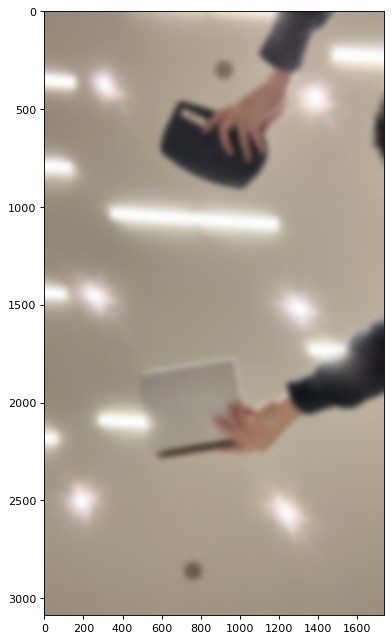

In [8]:
sigma = 15
background = skimage.filters.gaussian(im, sigma=(sigma, sigma))

plt.figure(figsize=(20, 10), dpi=80)
plt.imshow(background)

In [9]:
def add_blur(img, masks, depth):
    if len(depth) != len(masks):
        print("Number of depth is different from mask!")
        return
    
    sigma = 15
    background = skimage.filters.gaussian(img, sigma=(sigma, sigma))

    for i,mask in enumerate(masks):
        cur_obj = skimage.filters.gaussian(img, sigma=(sigma/depth[i], sigma/depth[i]))
        background[mask] = cur_obj[mask]

    plt.figure(figsize=(20, 10), dpi=80)
    plt.imshow(background)

<ipython-input-9-b977b3a4bfb3>:7: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  background = skimage.filters.gaussian(img, sigma=(sigma, sigma))
<ipython-input-9-b977b3a4bfb3>:10: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  cur_obj = skimage.filters.gaussian(img, sigma=(sigma/depth[i], sigma/depth[i]))


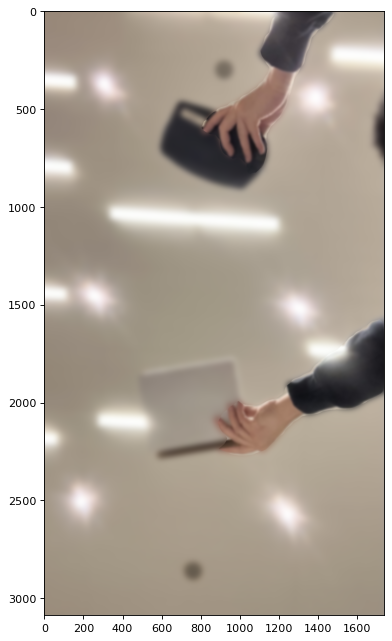

In [58]:
add_blur(im, outputs["instances"].pred_masks.to('cpu'), [3,3])

In [11]:
from point_cloud import *

Loading Point Cloud Data...
pointID 1216
x 1216
y 1216
z 1216
data_frames shape: (20, 3, 60)
Loading Success!
Clustering Success!
Cluster Pred: 
noises:  0 0.0
0 b 33 0.55
1 g 27 0.45


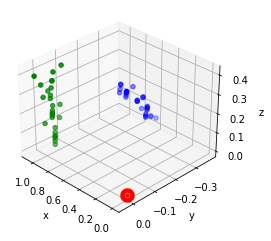

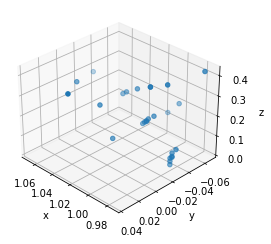

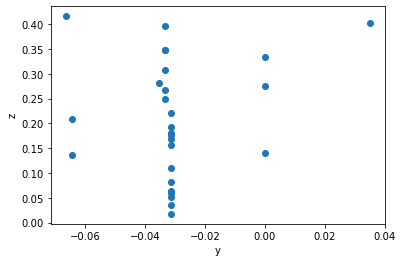

In [12]:
file_name = "/Users/xin/Desktop/millimeter wave/code_exp/cloud_point/stationary_2_items_facing_up_1m.txt"
pc = Point_Cloud(path=file_name, frame_size=60, eps=0.1, min_samples=5)
pc.plot_points(frame_id=6, cluster_idx=1)

In [ ]:
def sort_clsutering(clusters):
    s = np.mean(clusters, axis=0)
    return np.array(sorted(range(len(s)), key=lambda k: s[k][0]))

def sort_bouding_box(bounding_boxs):
    boxs = [np.sum(box, axis=0)/4 for box in bounding_boxs]
    return np.array(sorted(range(len(boxs)), key=lambda k: boxs[k][1]))

def find_matching(sorted_clusters, sorted_boxs):
    if len(sorted_clusters) == len(sorted_boxs):
        return np.array([(i,i) for i in range(len(sorted_clusters))])
    
    if len(sorted_boxs) > len(sorted_clusters):
        box_size = np.array([abs((k[0] - k[1])*(k[0]-k[-1])) for k in sorted_boxs])
        idx = np.array(sorted(range(len(box_size)), key=lambda k: box_size[k]))[:len(sorted_clusters)]
        return np.array([(i,idx[i]) for i in range(len(sorted_clusters))])
    else:
        cluster_size = np.array([len(k) for k in sorted_clusters])
        idx = np.array(sorted(range(len(cluster_size)), key=lambda k: cluster_size[k]))[:len(sorted_boxs)]
        return np.array([(idx[i], i) for i in range(len(sorted_boxs))])
    


def get_cluster_obj_matching(clusters, bounding_boxs):
    # sort clusters left to right
    clusters_idx = sort_clsutering(clusters)

    # sort bounding boxs left to right
    boxs_idx = sort_bouding_box(bounding_boxs)
    
    # find matching
    sorted_clusters = np.array(clusters)[clusters_idx]
    sorted_boxs = np.array(bounding_boxs)[boxs_idx]
    matching_pairs = find_matching(sorted_clusters, sorted_boxs)

    return matching_pairs

In [13]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [20]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [67]:
id2name_dict = {0: u'__background__',
 1: u'person',
 2: u'bicycle',
 3: u'car',
 4: u'motorcycle',
 5: u'airplane',
 6: u'bus',
 7: u'train',
 8: u'truck',
 9: u'boat',
 10: u'traffic light',
 11: u'fire hydrant',
 12: u'stop sign',
 13: u'parking meter',
 14: u'bench',
 15: u'bird',
 16: u'cat',
 17: u'dog',
 18: u'horse',
 19: u'sheep',
 20: u'cow',
 21: u'elephant',
 22: u'bear',
 23: u'zebra',
 24: u'giraffe',
 25: u'backpack',
 26: u'umbrella',
 27: u'handbag',
 28: u'tie',
 29: u'suitcase',
 30: u'frisbee',
 31: u'skis',
 32: u'snowboard',
 33: u'sports ball',
 34: u'kite',
 35: u'baseball bat',
 36: u'baseball glove',
 37: u'skateboard',
 38: u'surfboard',
 39: u'tennis racket',
 40: u'bottle',
 41: u'wine glass',
 42: u'cup',
 43: u'fork',
 44: u'knife',
 45: u'spoon',
 46: u'bowl',
 47: u'banana',
 48: u'apple',
 49: u'sandwich',
 50: u'orange',
 51: u'broccoli',
 52: u'carrot',
 53: u'hot dog',
 54: u'pizza',
 55: u'donut',
 56: u'cake',
 57: u'chair',
 58: u'couch',
 59: u'potted plant',
 60: u'bed',
 61: u'dining table',
 62: u'toilet',
 63: u'tv',
 64: u'laptop',
 65: u'mouse',
 66: u'remote',
 67: u'keyboard',
 68: u'cell phone',
 69: u'microwave',
 70: u'oven',
 71: u'toaster',
 72: u'sink',
 73: u'refrigerator',
 74: u'book',
 75: u'clock',
 76: u'vase',
 77: u'scissors',
 78: u'teddy bear',
 79: u'hair drier',
 80: u'toothbrush'}

In [72]:
def id2name(ids):
    print([id2name_dict[int(id)+1] for id in ids])

In [73]:
id2name(outputs["instances"].pred_classes)

['person', 'bed']
